# Probabilité d'erreur en fonction du RSB
<!-- vincent.mazet@unistra.fr, 03/2022 -->

Dans ce notebook, on représente le pourcentage d'erreur obtenu lors de la transmission d'un message binaire modulé en NRZ en fonction de la puissance du bruit, pour trois types de réception :
* sans filtre de réception (filtre adapté),
* avec filtre adapté et seuil au sens du maximum de vraisemblance (égal à 0 pour une modulation NRZ bipolaire) : c'est le seuil classique vu en cours,
* avec filtre adapté et seuil au sens du maximum a posteriori (qui prend en compte les probabilités d'émission des symboles).

Pour obtenir ces résultats, on génère une séquence binaire contenant un grand nombre de symboles pour obtenir des résultats significatifs.
Cette séquence est ensuite modulée, transmise via un canal idéal, et traitée avec les trois récepteurs étudiés.
On compare finalement la séquence binaire reçue avec la séquence binaire émise.

In [1]:
import numpy as np
import comnumfip as cnf
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore');

In [2]:
# Séquence binaire aléatoire
N = 2048
p = 0.8
c = cnf.randmary(N,[1-p, p])

# Amplitude et durée de la forme d'onde (modulation NRZ)
V, T = 1, 1
A0, A1 = -V, +V

# Nombre d'échantillons dans un symbole
L = 100
t, x = cnf.mod_d(c, V, T)

# Liste des RSB et des pourcentages d'erreurs de détection
rsbs = []
err1 = []
err2 = []
err3 = []

# Tests pour différents niveaux de bruits
sigs = np.logspace(-2, 1.5, 100)
for sig in sigs:
    
    # Canal (idéal)
    fc = np.inf
    y = cnf.channel(x,fc,sig,T)
    
    # RSB
    rsbs.append( 10*np.log10(sum(x**2)/sum((y-x)**2)) )
    
    # Filtre adapté
    g = V*np.ones(L)/L
    z = np.convolve(y, g, "same")

    # Échantillonnage
    idx = ( np.arange(N)*L + L/2+1 ).astype("int")
    
    # Seuil MV
    Smv = (A0+A1) / 2
    
    # Seuil MAP
    # Estimation de la variance de b~ par émission d'un signal x nul et estimation de la variance du signal z
    x0 = np.zeros(int(1e3))
    y0 = cnf.channel(x0,fc,sig,T)
    z0 = np.convolve(y0, g, "same")
    zsig = np.std(z0)
    A0, A1 = -V, V
    Smap = ( A0**2 - A1**2 + 2*zsig**2*np.log(p/(1-p)) ) / (2*(A0-A1))
    
    # Pourcentage d'erreur dans le cas sans filtre adapté
    r = np.where(y[idx]>Smv, 1, 0)
    err1.append( dist.hamming(r,c) )
    
    # Pourcentage d'erreur dans le cas avec filtre adapté et seuil MV
    r = np.where(z[idx]>Smv, 1, 0)
    err2.append( dist.hamming(r,c) )
    
    # Pourcentage d'erreur dans le cas avec filtre adapté et seuil MAP
    r = np.where(z[idx]>Smap, 1, 0)
    err3.append( dist.hamming(r,c) )

In [3]:
def myplot(x, y1, y2, y3, xlabel, ylabel):
    
    plt.figure(figsize=(10,6))
    plt.plot(x, y1, label="sans FA")
    plt.plot(x, y2, label="avec FA+MV")
    plt.plot(x, y3, label="avec FA+MAP")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

Dans un premier temps, on représente le pourcentage d'erreur en fonction de l'écart-type du bruit :

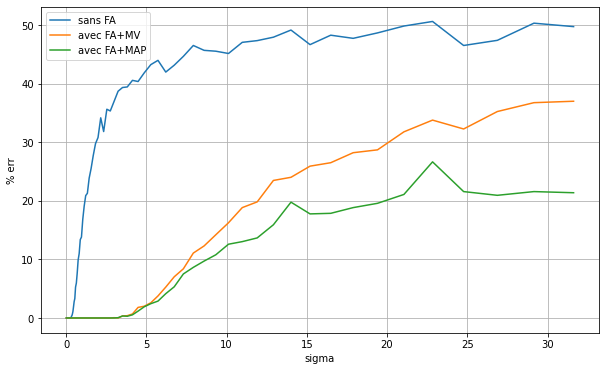

In [4]:
# Nombre d'erreurs en fonction de l'écart-type du bruit
myplot(sigs, np.array(err1)*100, np.array(err2)*100, np.array(err3)*100, xlabel="sigma", ylabel="% err")

On constate que le filtre adapté (courbes orange et verte) permet de réduire significativement les erreurs de transmission.
Si en plus on effectue un seuillage avec le seuil au sens du maximum a posteriori (courbe verte), alors on réduit encore le nombre d'erreurs.

Par ailleurs, on observe que le pourcentage d'erreur se stabilise aux alentours de 50 %.
Ce pourcentage est celui qu'on obtiendrait si le récepteur ne faisait que générer aléatoirement une séquence binaire sans considérer le signal reçu : c'est donc le pire résultat qu'on puisse obtenir.

Enfin, on constate que lorsque l'écart-type du bruit est faible, alors on est capable de ne pas faire d'erreur du tout !

Plutôt que d'utiliser le pourcentage d'erreur, on utilise plutôt le **BER** (_bit error rate_) qui est le pourcentage d'erreur exprimé en décibels (c'est le logarithme à base 10 du pourcentage d'erreur).

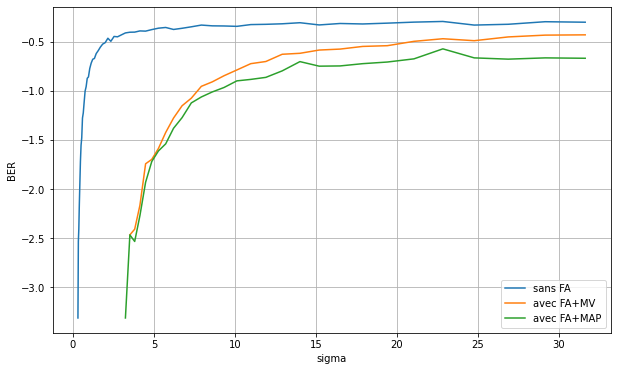

In [5]:
# BER (bit error rate) en fonction de l'écart-type du bruit
myplot(sigs, np.log10(err1), np.log10(err2), np.log10(err3), xlabel="sigma", ylabel="BER")

Enfin, il est généralement préférable d'exprimer la puissance du bruit en fonction du rapport signal-à-bruit (RSB) plutôt qu'en fonction de son écart-type.
En effet, le RSB tient compte de l'amplitude du bruit, mais également du signal sur lequel il est appliqué.

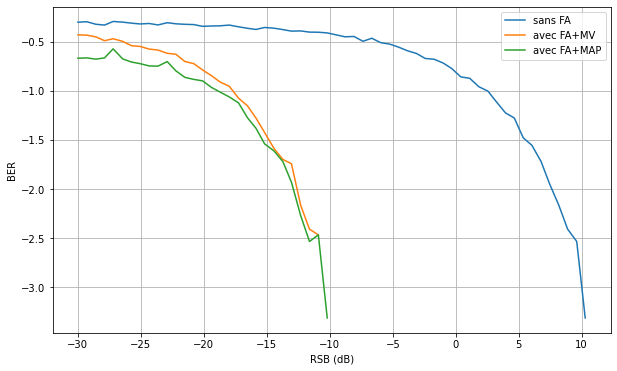

In [6]:
# BER (bit error rate) en fonction du RSB
myplot(rsbs, np.log10(err1), np.log10(err2), np.log10(err3), xlabel="RSB (dB)", ylabel="BER")

Ce type de représentation (BER en fonction du RSB) est très utilisé en communications numériques, pour comparer differntes méthodes.